<a href="https://colab.research.google.com/github/abhinav-sharma15/A-B-Testing-Metrics-in-Python/blob/main/A_B_Testing_Metrics_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B Testing Metrics in Python

In this notebook we'll introduce key metrics used in A/B testing, with Python examples:

- Conversion rate
- Difference in conversion (lift/uplift)
- Standard error (SE)
- z-score
- p-value and statistical significance
- Confidence level and confidence intervals
- Type I & II errors (α, β)
- Statistical power
- Minimum Detectable Effect (MDE)

We'll assume a simple **binary outcome** experiment (e.g. conversion vs no conversion).


In [2]:
import math
from dataclasses import dataclass
from typing import Tuple

import numpy as np
from scipy import stats


## 1. Conversion rate & lift

**Conversion rate** is the fraction of users who convert:

$\text{CR} = \frac{\text{conversions}}{\text{users}}$


Given two variants A and B:

- $  CR_A = \frac{X_A}{N_A} $
- $CR_B = \frac{X_B}{N_B} $

**Absolute lift (difference):**

$ Delta = CR_B - CR_A $


**Relative lift (percent):**

$\text{lift\%} = \frac{CR_B - CR_A}{CR_A} \times 100\%$


We'll start with a simple example.


In [3]:
# Example data
# Variant A (control)
n_A = 10000  # exposed
x_A = 500    # conversions

# Variant B (treatment)
n_B = 9800
x_B = 540

cr_A = x_A / n_A
cr_B = x_B / n_B

abs_lift = cr_B - cr_A
rel_lift_pct = abs_lift / cr_A * 100

cr_A, cr_B, abs_lift, rel_lift_pct


(0.05, 0.05510204081632653, 0.005102040816326529, 10.20408163265306)

## 2. Standard error (SE)

For a **single proportion** \( p = X/N \):


$ SE(p) = \sqrt{\frac{p (1 - p)}{N}} $


For the **difference in two independent proportions**:

$ SE(\Delta) = \sqrt{ SE(CR_A)^2 + SE(CR_B)^2 } $

We'll compute the SE for variant A, variant B, and the difference.


In [4]:
def se_proportion(p: float, n: int) -> float:
    return math.sqrt(p * (1 - p) / n)

se_A = se_proportion(cr_A, n_A)
se_B = se_proportion(cr_B, n_B)

se_diff = math.sqrt(se_A**2 + se_B**2)

se_A, se_B, se_diff


(0.0021794494717703367, 0.00230495929208824, 0.0031721975566133837)

## 3. z-score

The **z-score** measures how many standard errors the observed difference is away from 0 (no difference):

$z = \frac{\Delta}{SE(\Delta)} = \frac{CR_B - CR_A}{SE(\Delta)}$

With large sample sizes, the difference in proportions is approximately Normal, so we can use the standard normal distribution to compute p-values.


In [5]:
z_score = abs_lift / se_diff
z_score


1.6083616247953463

## 4. p-value & statistical significance

The **p-value** is the probability, under the null hypothesis \( H_0 \) (no true difference), of observing a result at least as extreme as what we saw.

For a **two-sided test**:

$p\text{-value} = 2 \times (1 - \Phi(|z|))$

where $( \Phi )$ is the CDF of the standard normal distribution.

We choose a **significance level** $(\alpha )$ (commonly 0.05):

- If $\ p\text{-value} \leq \alpha \ $: we say the result is **statistically significant** and reject \( H_0 \).
- If $\ p\text{-value} \geq \alpha \$: we **fail to reject** \( H_0 \).

Let's compute the p-value for our example.


In [6]:
alpha = 0.05  # 5% significance level

p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))

is_significant = p_value <= alpha
p_value, is_significant


(np.float64(0.10775600120675843), np.False_)

## 5. Confidence level & confidence intervals

A **confidence level** (e.g. 95%) tells us how often, across many repeated experiments, the constructed intervals would contain the true parameter.

For a difference in proportions, an approximate **(1 - α) 100% confidence interval** is:

$\Delta \pm z_{1-\alpha/2} \times SE(\Delta)$

where \( z_{1-\alpha/2} \) is the critical value of the standard normal distribution (for 95% it's ~1.96).

This CI gives a range of plausible values for \( CR_B - CR_A \).

We'll compute:

- 95% CI for the **difference**
- 95% CI for each group's **conversion rate**


In [7]:
def ci_for_proportion(p: float, n: int, alpha: float = 0.05) -> Tuple[float, float]:
    se = se_proportion(p, n)
    z_crit = stats.norm.ppf(1 - alpha / 2)
    return p - z_crit * se, p + z_crit * se

def ci_for_diff(cr_A, n_A, cr_B, n_B, alpha=0.05):
    se_A = se_proportion(cr_A, n_A)
    se_B = se_proportion(cr_B, n_B)
    se_diff = math.sqrt(se_A**2 + se_B**2)
    z_crit = stats.norm.ppf(1 - alpha / 2)
    diff = cr_B - cr_A
    return diff - z_crit * se_diff, diff + z_crit * se_diff

ci_A = ci_for_proportion(cr_A, n_A, alpha)
ci_B = ci_for_proportion(cr_B, n_B, alpha)
ci_diff = ci_for_diff(cr_A, n_A, cr_B, n_B, alpha)

ci_A, ci_B, ci_diff


((np.float64(0.045728357529205295), np.float64(0.05427164247079471)),
 (np.float64(0.05058440361800264), np.float64(0.05961967801465042)),
 (np.float64(-0.0011153521464816619), np.float64(0.01131943377913472)))

## 6. Type I & Type II errors

In hypothesis testing we have two kinds of errors:

- **Type I error (α):** rejecting \( H_0 \) when it's actually true (false positive).
  - We choose α (e.g. 5%) as our acceptable risk.

- **Type II error (β):** failing to reject \( H_0 \) when the alternative \( H_1 \) is true (false negative).
  - β depends on sample size, effect size, and α.

We often talk about **controlling α** (e.g. 0.05) and **maximizing power**, where:

$\text{Power} = 1 - \beta = P(\text{reject } H_0 \mid H_1 \text{ is true})$

Next, we'll compute the **power** for a given effect size using simulation and an analytical approximation.


## 7. Statistical power

Given:
- Baseline conversion \( p_A \)
- Assumed true treatment conversion \( p_B \)
- Sample sizes \( N_A, N_B \)
- Significance level \($\alpha )$

we can compute the probability that our test correctly detects the difference (i.e., the chance we get a statistically significant result).

We'll implement:

1. A **quick analytical approximation** using the normal distribution.
2. A **simulation-based estimate** using random draws (binomial).


In [8]:
def power_two_proportions(
    p_A: float,
    p_B: float,
    n_A: int,
    n_B: int,
    alpha: float = 0.05,
) -> float:
    """
    Approximate power for a two-sided z-test on two independent proportions.
    """
    # True SE under alternative (using true p_A, p_B)
    se_A = se_proportion(p_A, n_A)
    se_B = se_proportion(p_B, n_B)
    se_diff_true = math.sqrt(se_A**2 + se_B**2)

    delta = p_B - p_A
    z_crit = stats.norm.ppf(1 - alpha / 2)

    # Under H1, z ~ Normal(mean = delta / se_diff_true, sd = 1)
    mean_z = delta / se_diff_true

    # Power = P(z > z_crit or z < -z_crit) under H1
    # = 1 - P(-z_crit <= Z <= z_crit)
    lower = -z_crit
    upper = z_crit

    power = 1 - (stats.norm.cdf(upper, loc=mean_z, scale=1) -
                 stats.norm.cdf(lower, loc=mean_z, scale=1))

    return power

# Example: what's the power to detect from 5% to 5.5%, with n_A = n_B = 10k?
p_A_baseline = 0.05
p_B_true = 0.055
n_A_plan = 10_000
n_B_plan = 10_000

power_est = power_two_proportions(p_A_baseline, p_B_true, n_A_plan, n_B_plan, alpha=0.05)
power_est


np.float64(0.3541534284704122)

In [9]:
def simulate_power(
    p_A: float,
    p_B: float,
    n_A: int,
    n_B: int,
    alpha: float = 0.05,
    n_sims: int = 10_000,
    random_state: int = 42,
) -> float:
    rng = np.random.default_rng(random_state)

    rejections = 0
    for _ in range(n_sims):
        x_A_sim = rng.binomial(n_A, p_A)
        x_B_sim = rng.binomial(n_B, p_B)

        cr_A_sim = x_A_sim / n_A
        cr_B_sim = x_B_sim / n_B

        se_A_sim = se_proportion(cr_A_sim, n_A)
        se_B_sim = se_proportion(cr_B_sim, n_B)
        se_diff_sim = math.sqrt(se_A_sim**2 + se_B_sim**2)

        if se_diff_sim == 0:
            continue

        z_sim = (cr_B_sim - cr_A_sim) / se_diff_sim
        p_val_sim = 2 * (1 - stats.norm.cdf(abs(z_sim)))

        if p_val_sim <= alpha:
            rejections += 1

    return rejections / n_sims

sim_power = simulate_power(p_A_baseline, p_B_true, n_A_plan, n_B_plan, alpha=0.05, n_sims=2000)
power_est, sim_power


(np.float64(0.3541534284704122), 0.3605)

## 8. Minimum Detectable Effect (MDE)

The **Minimum Detectable Effect (MDE)** is the smallest effect size (difference in conversion) that an experiment can reliably detect with:

- A given sample size
- A chosen significance level$( \alpha )$
- A target power (e.g. 80% or 90%)

Formally, for given $( N_A, N_B, \alpha, \text{power} )$, and baseline \( p_A \), the MDE is:

$\text{MDE} = p_B - p_A$

such that:

$\text{Power}(p_A, p_B, N_A, N_B, \alpha) = \text{target power}$

We'll solve for \( p_B \) numerically using a simple search.


In [10]:
def mde_two_proportions(
    p_A: float,
    n_A: int,
    n_B: int,
    alpha: float = 0.05,
    target_power: float = 0.8,
    tol: float = 1e-4,
    max_iter: int = 100,
) -> float:
    """
    Approximate MDE (absolute difference) for a two-sided test
    given baseline p_A, sample sizes, alpha, and target_power.
    Uses binary search over p_B.
    """
    # Search over p_B in [p_A, upper_bound], say up to +20 percentage points
    low = p_A
    high = min(1.0, p_A + 0.2)

    for _ in range(max_iter):
        mid = (low + high) / 2
        current_power = power_two_proportions(p_A, mid, n_A, n_B, alpha)

        if abs(current_power - target_power) < tol:
            return mid - p_A

        if current_power < target_power:
            # need larger effect
            low = mid
        else:
            # effect is too large, can decrease
            high = mid

    return (low + high) / 2 - p_A  # best guess

# Example: baseline 5%, n_A = n_B = 10k, alpha=0.05, target power=80%
mde = mde_two_proportions(p_A=0.05, n_A=10_000, n_B=10_000, alpha=0.05, target_power=0.8)
mde, mde / 0.05 * 100


(0.008992004394531246, 17.984008789062493)

## 9. Helper: one function to compute all key metrics

We'll define a helper function that, given:

- (n_A, x_A)
- (n_B, x_B)
- α (significance level)

returns:

- Conversion rates
- Absolute & relative lift
- z-score
- p-value & significance flag
- Confidence interval for the difference


In [11]:
@dataclass
class ABTestSummary:
    cr_A: float
    cr_B: float
    abs_lift: float
    rel_lift_pct: float
    z_score: float
    p_value: float
    is_significant: bool
    ci_diff_low: float
    ci_diff_high: float
    alpha: float

def summarize_ab_test(n_A: int, x_A: int, n_B: int, x_B: int, alpha: float = 0.05) -> ABTestSummary:
    cr_A = x_A / n_A
    cr_B = x_B / n_B
    abs_lift = cr_B - cr_A
    rel_lift_pct = abs_lift / cr_A * 100

    se_A = se_proportion(cr_A, n_A)
    se_B = se_proportion(cr_B, n_B)
    se_diff = math.sqrt(se_A**2 + se_B**2)

    z = abs_lift / se_diff
    p_val = 2 * (1 - stats.norm.cdf(abs(z)))
    is_sig = p_val <= alpha

    ci_low, ci_high = ci_for_diff(cr_A, n_A, cr_B, n_B, alpha)

    return ABTestSummary(
        cr_A=cr_A,
        cr_B=cr_B,
        abs_lift=abs_lift,
        rel_lift_pct=rel_lift_pct,
        z_score=z,
        p_value=p_val,
        is_significant=is_sig,
        ci_diff_low=ci_low,
        ci_diff_high=ci_high,
        alpha=alpha,
    )

summary = summarize_ab_test(n_A, x_A, n_B, x_B, alpha=0.05)
summary


ABTestSummary(cr_A=0.05, cr_B=0.05510204081632653, abs_lift=0.005102040816326529, rel_lift_pct=10.20408163265306, z_score=1.6083616247953463, p_value=np.float64(0.10775600120675843), is_significant=np.False_, ci_diff_low=np.float64(-0.0011153521464816619), ci_diff_high=np.float64(0.01131943377913472), alpha=0.05)

## 10. Bayesian A/B metrics for A/B tests

So far we used **frequentist** metrics (p-values, CIs, power).

Now let's add **Bayesian** quantities for two-proportion experiments.

Assume:
- For each variant (A or B), the conversion rate \( p \) has a **Beta prior**:
  $p \sim \text{Beta}(\alpha_0, \beta_0)$
- Observations: \( X \) conversions out of \( N \) users:
  $X \mid p \sim \text{Binomial}(N, p)$

With a **conjugate prior** Beta–Binomial model, the posterior is:

$p \mid X \sim \text{Beta}(\alpha_0 + X, \beta_0 + N - X)$

We'll typically use a **flat prior**:
- $( \alpha_0 = 1, \beta_0 = 1 )$  (uniform on [0, 1])

We’ll compute:

- Posterior means for \( p_A, p_B \)
- 95% **credible intervals** for \( p_A, p_B \)
- The **posterior probability** that B is better than A:
  $P(p_B > p_A \mid \text{data})$
- The posterior distribution of **lift** (p_B - p_A) and its 95% credible interval

We'll approximate these using Monte Carlo sampling from the posterior Beta distributions.


In [12]:
from scipy.stats import beta

@dataclass
class BayesianABSummary:
    alpha_prior: float
    beta_prior: float
    post_a_alpha: float
    post_a_beta: float
    post_b_alpha: float
    post_b_beta: float
    post_mean_A: float
    post_mean_B: float
    ci_A_low: float
    ci_A_high: float
    ci_B_low: float
    ci_B_high: float
    prob_B_superior: float
    lift_mean: float
    lift_ci_low: float
    lift_ci_high: float


def bayesian_ab_summary(
    n_A: int,
    x_A: int,
    n_B: int,
    x_B: int,
    alpha_prior: float = 1.0,
    beta_prior: float = 1.0,
    cred_level: float = 0.95,
    n_samples: int = 50_000,
    random_state: int = 123,
) -> BayesianABSummary:
    """
    Bayesian A/B summary using Beta-Binomial conjugate model
    and Monte Carlo sampling for probabilities and lift.
    """
    rng = np.random.default_rng(random_state)

    # Posterior parameters
    post_a_alpha = alpha_prior + x_A
    post_a_beta = beta_prior + (n_A - x_A)
    post_b_alpha = alpha_prior + x_B
    post_b_beta = beta_prior + (n_B - x_B)

    # Posterior means
    post_mean_A = post_a_alpha / (post_a_alpha + post_a_beta)
    post_mean_B = post_b_alpha / (post_b_alpha + post_b_beta)

    # Credible intervals for A and B
    lower_q = (1 - cred_level) / 2
    upper_q = 1 - lower_q

    ci_A_low = beta.ppf(lower_q, post_a_alpha, post_a_beta)
    ci_A_high = beta.ppf(upper_q, post_a_alpha, post_a_beta)

    ci_B_low = beta.ppf(lower_q, post_b_alpha, post_b_beta)
    ci_B_high = beta.ppf(upper_q, post_b_alpha, post_b_beta)

    # Monte Carlo to get P(B > A) and lift distribution
    samples_A = rng.beta(post_a_alpha, post_a_beta, size=n_samples)
    samples_B = rng.beta(post_b_alpha, post_b_beta, size=n_samples)

    prob_B_superior = float(np.mean(samples_B > samples_A))

    lift_samples = samples_B - samples_A
    lift_mean = float(np.mean(lift_samples))
    lift_ci_low = float(np.quantile(lift_samples, lower_q))
    lift_ci_high = float(np.quantile(lift_samples, upper_q))

    return BayesianABSummary(
        alpha_prior=alpha_prior,
        beta_prior=beta_prior,
        post_a_alpha=post_a_alpha,
        post_a_beta=post_a_beta,
        post_b_alpha=post_b_alpha,
        post_b_beta=post_b_beta,
        post_mean_A=post_mean_A,
        post_mean_B=post_mean_B,
        ci_A_low=ci_A_low,
        ci_A_high=ci_A_high,
        ci_B_low=ci_B_low,
        ci_B_high=ci_B_high,
        prob_B_superior=prob_B_superior,
        lift_mean=lift_mean,
        lift_ci_low=lift_ci_low,
        lift_ci_high=lift_ci_high,
    )

# Example on our existing numbers
bayes_summary = bayesian_ab_summary(n_A, x_A, n_B, x_B)
bayes_summary


BayesianABSummary(alpha_prior=1.0, beta_prior=1.0, post_a_alpha=501.0, post_a_beta=9501.0, post_b_alpha=541.0, post_b_beta=9261.0, post_mean_A=0.05008998200359928, post_mean_B=0.05519281779228729, ci_A_low=np.float64(0.045901268594915445), ci_A_high=np.float64(0.0544490948996101), ci_B_low=np.float64(0.05075903379721136), ci_B_high=np.float64(0.05979850793201578), prob_B_superior=0.9469, lift_mean=0.005102819234936477, lift_ci_low=-0.0011486299430256604, lift_ci_high=0.011331104689911208)

## 11. Sample size calculator (frequentist)

We often want to plan an experiment up front. Given:

- Baseline conversion \( p_A \)
- Target **Minimum Detectable Effect (MDE)** \( \delta = p_B - p_A \)
- Significance level \( \alpha \) (e.g. 0.05)
- Desired **power** (e.g. 0.8 or 0.9)

we can approximate the **required sample size per group** for a two-sided z-test on proportions.

A common approximation for equal-sized groups:

Let:
- $( p_1 = p_A )$
- $( p_2 = p_A + \delta )$
- $( \bar{p} = (p_1 + p_2) / 2 )$
- $( z_{1-\alpha/2} )$ = critical value for significance
- $( z_{1-\beta} )$ = critical value for power (where $( \beta = 1 - \text{power} )$)

Then:

$n \approx \frac{\left[
z_{1-\alpha/2}\sqrt{2\bar{p}(1-\bar{p})} +
z_{1-\beta}\sqrt{p_1(1-p_1) + p_2(1-p_2)}
\right]^2}{(p_2 - p_1)^2}$

We'll implement a helper that returns:

- `n_per_group` (rounded up)
- `total_n`


In [13]:
@dataclass
class SampleSizeResult:
    p_A: float
    p_B: float
    mde: float
    alpha: float
    power: float
    n_per_group: int
    total_n: int


def sample_size_two_proportions(
    p_A: float,
    mde: float,
    alpha: float = 0.05,
    power: float = 0.8,
) -> SampleSizeResult:
    """
    Approximate sample size per group for a two-sided z-test
    for two independent proportions with equal allocation.
    """
    p_B = p_A + mde
    if not (0 < p_A < 1 and 0 < p_B < 1):
        raise ValueError("p_A and p_A + mde must both be between 0 and 1.")

    p1 = p_A
    p2 = p_B
    p_bar = (p1 + p2) / 2

    z_alpha = stats.norm.ppf(1 - alpha / 2)
    z_beta = stats.norm.ppf(power)

    num = (
        z_alpha * math.sqrt(2 * p_bar * (1 - p_bar)) +
        z_beta * math.sqrt(p1 * (1 - p1) + p2 * (1 - p2))
    ) ** 2
    denom = (p2 - p1) ** 2

    n_per_group = math.ceil(num / denom)
    total_n = 2 * n_per_group

    return SampleSizeResult(
        p_A=p_A,
        p_B=p_B,
        mde=mde,
        alpha=alpha,
        power=power,
        n_per_group=n_per_group,
        total_n=total_n,
    )

# Example: baseline 5%, want to detect +0.5pp (5% → 5.5%), 5% alpha, 80% power
ss_result = sample_size_two_proportions(p_A=0.05, mde=0.005, alpha=0.05, power=0.8)
ss_result


SampleSizeResult(p_A=0.05, p_B=0.055, mde=0.005, alpha=0.05, power=0.8, n_per_group=31234, total_n=62468)

## 12. Example dataset: A/B experiments end-to-end

We'll create a small dataset with multiple A/B experiments:

Columns:
- `experiment_id`
- `n_A`, `x_A`
- `n_B`, `x_B`
- `baseline_guess` (planned or historical baseline for sample size calcs)
- `target_mde` (minimal uplift we care to detect in a future test)

For each row, we'll compute:

1. **Frequentist metrics** via `summarize_ab_test`
2. **Bayesian metrics** via `bayesian_ab_summary`
3. **Recommended sample size** for a future test with the given baseline + MDE


In [14]:
import pandas as pd

data = [
    {
        "experiment_id": "exp_1",
        "n_A": 10000,
        "x_A": 500,
        "n_B": 9800,
        "x_B": 540,
        "baseline_guess": 0.05,
        "target_mde": 0.005,  # +0.5pp
    },
    {
        "experiment_id": "exp_2",
        "n_A": 15000,
        "x_A": 750,
        "n_B": 15050,
        "x_B": 840,
        "baseline_guess": 0.05,
        "target_mde": 0.004,  # +0.4pp
    },
    {
        "experiment_id": "exp_3",
        "n_A": 8000,
        "x_A": 640,
        "n_B": 8200,
        "x_B": 754,
        "baseline_guess": 0.08,
        "target_mde": 0.006,  # +0.6pp
    },
]

df_experiments = pd.DataFrame(data)
df_experiments


,experiment_id,n_A,x_A,n_B,x_B,baseline_guess,target_mde
0,exp_1,10000,500,9800,540,0.05,0.005
1,exp_2,15000,750,15050,840,0.05,0.004
2,exp_3,8000,640,8200,754,0.08,0.006


In [15]:
def full_analysis_row(row, alpha=0.05, cred_level=0.95, power=0.8):
    # Frequentist summary
    freq = summarize_ab_test(
        n_A=row["n_A"],
        x_A=row["x_A"],
        n_B=row["n_B"],
        x_B=row["x_B"],
        alpha=alpha,
    )

    # Bayesian summary (uniform prior Beta(1,1))
    bayes = bayesian_ab_summary(
        n_A=row["n_A"],
        x_A=row["x_A"],
        n_B=row["n_B"],
        x_B=row["x_B"],
        alpha_prior=1.0,
        beta_prior=1.0,
        cred_level=cred_level,
        n_samples=30_000,  # reduce if you want faster execution
    )

    # Sample size planning for a future similar experiment
    ss = sample_size_two_proportions(
        p_A=row["baseline_guess"],
        mde=row["target_mde"],
        alpha=alpha,
        power=power,
    )

    return pd.Series(
        {
            # Frequentist
            "cr_A": freq.cr_A,
            "cr_B": freq.cr_B,
            "abs_lift": freq.abs_lift,
            "rel_lift_pct": freq.rel_lift_pct,
            "p_value": freq.p_value,
            "is_significant": freq.is_significant,
            "ci_diff_low": freq.ci_diff_low,
            "ci_diff_high": freq.ci_diff_high,
            # Bayesian
            "post_mean_A": bayes.post_mean_A,
            "post_mean_B": bayes.post_mean_B,
            "ci_A_low": bayes.ci_A_low,
            "ci_A_high": bayes.ci_A_high,
            "ci_B_low": bayes.ci_B_low,
            "ci_B_high": bayes.ci_B_high,
            "prob_B_superior": bayes.prob_B_superior,
            "lift_mean_posterior": bayes.lift_mean,
            "lift_ci_low": bayes.lift_ci_low,
            "lift_ci_high": bayes.lift_ci_high,
            # Sample size recommendation (future)
            "ss_n_per_group": ss.n_per_group,
            "ss_total_n": ss.total_n,
        }
    )

results = df_experiments.apply(full_analysis_row, axis=1)
results_full = pd.concat([df_experiments[["experiment_id"]], results], axis=1)

pd.set_option("display.float_format", lambda x: f"{x:0.6f}")
results_full


,experiment_id,cr_A,cr_B,abs_lift,rel_lift_pct,p_value,is_significant,ci_diff_low,ci_diff_high,post_mean_A,...,ci_A_low,ci_A_high,ci_B_low,ci_B_high,prob_B_superior,lift_mean_posterior,lift_ci_low,lift_ci_high,ss_n_per_group,ss_total_n
0,exp_1,0.050000,0.055102,0.005102,10.204082,0.107756,False,-0.001115,0.011319,0.050090,...,0.045901,0.054449,0.050759,0.059799,0.947600,0.005107,-0.001062,0.011350,31234,62468
1,exp_2,0.050000,0.055814,0.005814,11.627907,0.024356,True,0.000753,0.010875,0.050060,...,0.046628,0.053606,0.052260,0.059598,0.986667,0.005801,0.000664,0.010907,48364,96728
2,exp_3,0.080000,0.091951,0.011951,14.939024,0.006635,True,0.003322,0.020580,0.080105,...,0.074258,0.086151,0.085889,0.098400,0.996267,0.011940,0.003339,0.020481,33187,66374


## 13. Interpreting the example output

For each experiment:

- `cr_A`, `cr_B` – observed conversion rates.
- `abs_lift`, `rel_lift_pct` – observed difference and percent uplift.
- `p_value`, `is_significant` – frequentist test result at α (e.g. 0.05).
- `ci_diff_low`, `ci_diff_high` – 95% confidence interval for the difference.

From the Bayesian perspective:

- `post_mean_A`, `post_mean_B` – posterior means for A and B.
- `ci_A_low`, `ci_A_high`, `ci_B_low`, `ci_B_high` – 95% credible intervals.
- `prob_B_superior` – posterior probability that B is truly better than A.
- `lift_mean_posterior`, `lift_ci_low`, `lift_ci_high` – posterior distribution of the lift.

For planning:

- `ss_n_per_group` – recommended sample size per variant in a **future** experiment
  with the given `baseline_guess` and `target_mde`, at the chosen α and power.
- `ss_total_n` – total users needed (A + B).

This gives you a full **end-to-end A/B testing notebook** with both frequentist and Bayesian views,
plus a practical sample size calculator and a multi-experiment example dataset.


## 14. Plotting setup

We'll use `matplotlib` for plots:

- Posterior distributions for A and B
- Posterior lift distribution (B − A)
- Power curve vs sample size

Each plot will be a separate figure.


In [16]:
import matplotlib.pyplot as plt

# Optional in Jupyter:
# %matplotlib inline


## 15. Posterior distributions of conversion rates (A vs B)

We'll:

1. Take a single experiment (e.g. `exp_1`).
2. Compute its Bayesian summary (posterior Beta parameters).
3. Plot the posterior densities of \( p_A \) and \( p_B \) on the same axis.

This gives a visual sense of:
- Where each variant’s true conversion is likely to lie.
- How much they overlap.


In [17]:
# Choose an experiment to visualize (here: first row / exp_1)
row = df_experiments.iloc[0]

n_A_vis = row["n_A"]
x_A_vis = row["x_A"]
n_B_vis = row["n_B"]
x_B_vis = row["x_B"]

bayes_vis = bayesian_ab_summary(
    n_A=n_A_vis,
    x_A=x_A_vis,
    n_B=n_B_vis,
    x_B=x_B_vis,
    alpha_prior=1.0,
    beta_prior=1.0,
    cred_level=0.95,
    n_samples=50_000,
)

bayes_vis


BayesianABSummary(alpha_prior=1.0, beta_prior=1.0, post_a_alpha=np.float64(501.0), post_a_beta=np.float64(9501.0), post_b_alpha=np.float64(541.0), post_b_beta=np.float64(9261.0), post_mean_A=np.float64(0.05008998200359928), post_mean_B=np.float64(0.05519281779228729), ci_A_low=np.float64(0.045901268594915445), ci_A_high=np.float64(0.0544490948996101), ci_B_low=np.float64(0.05075903379721136), ci_B_high=np.float64(0.05979850793201578), prob_B_superior=0.9469, lift_mean=0.005102819234936477, lift_ci_low=-0.0011486299430256604, lift_ci_high=0.011331104689911208)

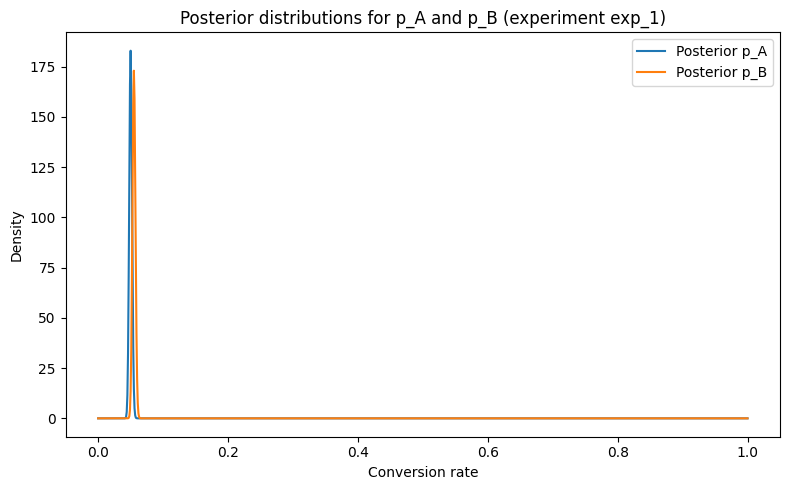

In [18]:
# Grid over [0, 1] to evaluate the Beta pdfs
x_grid = np.linspace(0, 1, 1000)

pdf_A = beta.pdf(x_grid, bayes_vis.post_a_alpha, bayes_vis.post_a_beta)
pdf_B = beta.pdf(x_grid, bayes_vis.post_b_alpha, bayes_vis.post_b_beta)

plt.figure(figsize=(8, 5))
plt.plot(x_grid, pdf_A, label="Posterior p_A")
plt.plot(x_grid, pdf_B, label="Posterior p_B")
plt.xlabel("Conversion rate")
plt.ylabel("Density")
plt.title(f"Posterior distributions for p_A and p_B (experiment {row['experiment_id']})")
plt.legend()
plt.tight_layout()
plt.show()


## 16. Posterior lift distribution (B − A)

Using posterior samples:

- Draw samples from \( p_A \) and \( p_B \)
- Compute `lift = p_B - p_A` for each sample
- Plot the distribution of `lift`

This shows:
- Central tendency (mean lift)
- Spread/uncertainty
- How much mass is above 0 (should match `prob_B_superior`)


In [19]:
# Re-sample to get lift samples for plotting
rng = np.random.default_rng(123)

n_samples_plot = 50_000
samples_A_plot = rng.beta(bayes_vis.post_a_alpha, bayes_vis.post_a_beta, size=n_samples_plot)
samples_B_plot = rng.beta(bayes_vis.post_b_alpha, bayes_vis.post_b_beta, size=n_samples_plot)

lift_samples_plot = samples_B_plot - samples_A_plot

lift_mean_plot = np.mean(lift_samples_plot)
lift_ci_low_plot = np.quantile(lift_samples_plot, 0.025)
lift_ci_high_plot = np.quantile(lift_samples_plot, 0.975)
prob_B_superior_plot = np.mean(lift_samples_plot > 0)

lift_mean_plot, lift_ci_low_plot, lift_ci_high_plot, prob_B_superior_plot


(np.float64(0.005102819234936477),
 np.float64(-0.0011486299430256606),
 np.float64(0.011331104689911208),
 np.float64(0.9469))

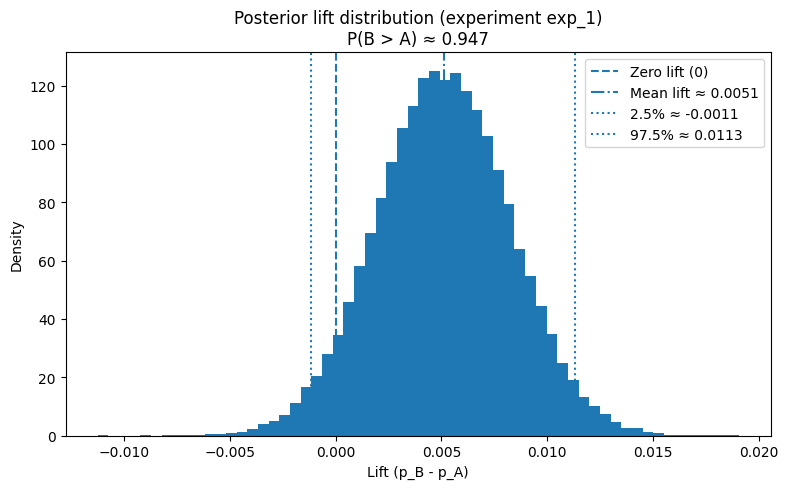

In [20]:
plt.figure(figsize=(8, 5))
plt.hist(lift_samples_plot, bins=60, density=True)
plt.axvline(0, linestyle="--", label="Zero lift (0)")
plt.axvline(lift_mean_plot, linestyle="-.", label=f"Mean lift ≈ {lift_mean_plot:.4f}")
plt.axvline(lift_ci_low_plot, linestyle=":", label=f"2.5% ≈ {lift_ci_low_plot:.4f}")
plt.axvline(lift_ci_high_plot, linestyle=":", label=f"97.5% ≈ {lift_ci_high_plot:.4f}")
plt.xlabel("Lift (p_B - p_A)")
plt.ylabel("Density")
plt.title(f"Posterior lift distribution (experiment {row['experiment_id']})\n"
          f"P(B > A) ≈ {prob_B_superior_plot:.3f}")
plt.legend()
plt.tight_layout()
plt.show()


## 17. Power curve vs sample size

We'll fix:

- Baseline conversion \( p_A \) (e.g. 5%)
- True treatment conversion $( p_B = p_A + \text{MDE} )$ (e.g. +0.5pp)
- Significance level $( \alpha ) $(e.g. 0.05)

Then, for a range of `n_per_group`, we compute:

$\text{Power}(n) = P(\text{reject } H_0 \mid p_A, p_B, n)$

and plot power vs `n_per_group`.


In [21]:
# Parameters for the power curve
p_A_curve = 0.05
mde_curve = 0.005   # +0.5 percentage points
p_B_curve = p_A_curve + mde_curve
alpha_curve = 0.05

n_values = np.arange(2000, 30001, 2000)  # 2k to 30k per group
power_values = [
    power_two_proportions(p_A_curve, p_B_curve, n, n, alpha=alpha_curve)
    for n in n_values
]

list(zip(n_values, power_values))[:5]  # peek


[(np.int64(2000), np.float64(0.10927300372172677)),
 (np.int64(4000), np.float64(0.17072597794815247)),
 (np.int64(6000), np.float64(0.232803355164782)),
 (np.int64(8000), np.float64(0.2942663847684893)),
 (np.int64(10000), np.float64(0.3541534284704122))]

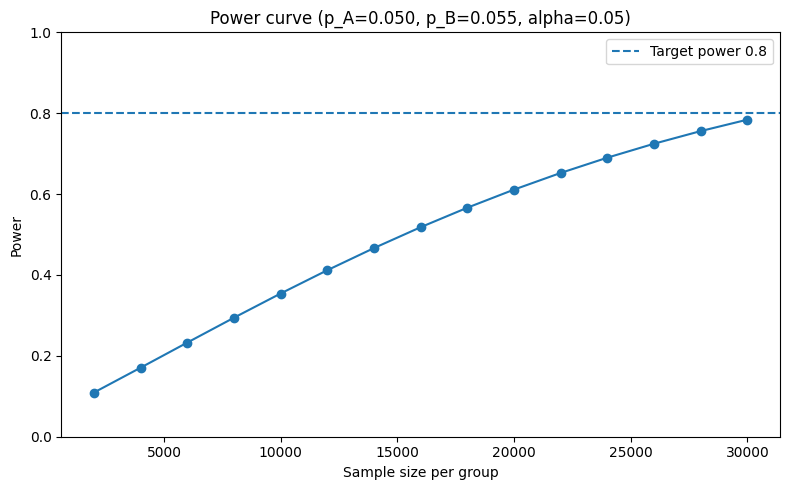

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(n_values, power_values, marker="o")
plt.axhline(0.8, linestyle="--", label="Target power 0.8")
plt.xlabel("Sample size per group")
plt.ylabel("Power")
plt.title(f"Power curve (p_A={p_A_curve:.3f}, p_B={p_B_curve:.3f}, alpha={alpha_curve})")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


## 18. Optional: Plot observed lift and confidence intervals by experiment

We can:

- Take the `results_full` table with `abs_lift`, `ci_diff_low`, `ci_diff_high`.
- Plot a point for each experiment's observed lift.
- Add an error bar from `ci_diff_low` to `ci_diff_high`.

This is a compact way to compare experiments and see which ones are statistically significant (CIs excluding 0).


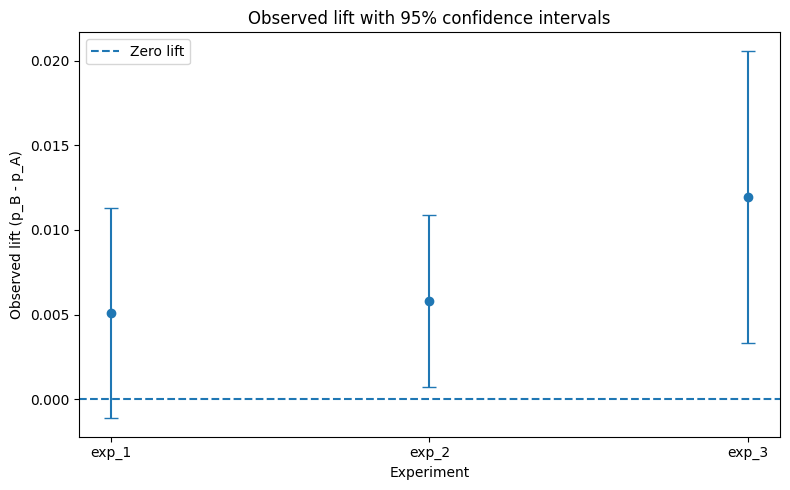

In [23]:
exp_ids = results_full["experiment_id"].values
x_pos = np.arange(len(exp_ids))

lift = results_full["abs_lift"].values
ci_low = results_full["ci_diff_low"].values
ci_high = results_full["ci_diff_high"].values

errors_lower = lift - ci_low
errors_upper = ci_high - lift

plt.figure(figsize=(8, 5))
plt.errorbar(
    x_pos,
    lift,
    yerr=[errors_lower, errors_upper],
    fmt="o",
    capsize=5,
)
plt.axhline(0, linestyle="--", label="Zero lift")
plt.xticks(x_pos, exp_ids)
plt.xlabel("Experiment")
plt.ylabel("Observed lift (p_B - p_A)")
plt.title("Observed lift with 95% confidence intervals")
plt.legend()
plt.tight_layout()
plt.show()


# 19. Frequentist vs Bayesian in Practical Product Decisions

In product experimentation, the goal is not academic:  
**We want to make a decision** — *ship or don’t ship?*  
Not: “reject or fail to reject H₀”.

Frequentist and Bayesian methods can lead to **different practical conclusions**,
especially in:

- small-sample experiments  
- borderline p-values  
- weak but meaningful product lifts  

Below we construct **three realistic A/B testing scenarios** that highlight
how the methods differ *in decisions*.

We will analyze:

### **Scenario A — Small sample, moderate lift**
Frequentist: probably NOT significant  
Bayesian: may already show strong probability B > A  

### **Scenario B — Large sample, tiny lift**
Frequentist: often significant  
Bayesian: may say “improvement is tiny & probably doesn’t matter”  

### **Scenario C — Borderline p-value (p ≈ 0.055)**
Frequentist: “Not significant”  
Bayesian: “B is better with ~70–80% probability”

These are **typical real-world A/B cases**.

We will compute for each scenario:

- p-value
- confidence interval
- Bayesian posterior probability B > A
- posterior lift credible interval

Then we compare what decision each approach would push you toward.


In [24]:
scenario_data = [
    # Scenario A: Small sample, decent effect
    {
        "scenario": "A_small_sample_moderate_lift",
        "n_A": 800,
        "x_A": 56,      # 7%
        "n_B": 820,
        "x_B": 74,      # 9%
    },
    # Scenario B: Large sample, tiny effect
    {
        "scenario": "B_large_sample_tiny_lift",
        "n_A": 60000,
        "x_A": 3000,    # 5.00%
        "n_B": 60500,
        "x_B": 3090,    # 5.11%
    },
    # Scenario C: Borderline p-value
    {
        "scenario": "C_borderline_significance",
        "n_A": 20000,
        "x_A": 1000,     # 5.00%
        "n_B": 20000,
        "x_B": 1060,     # 5.30%
    },
]

df_scenarios = pd.DataFrame(scenario_data)
df_scenarios


,scenario,n_A,x_A,n_B,x_B
0,A_small_sample_moderate_lift,800,56,820,74
1,B_large_sample_tiny_lift,60000,3000,60500,3090
2,C_borderline_significance,20000,1000,20000,1060


In [25]:
def analyze_scenario(row):
    freq = summarize_ab_test(
        row["n_A"], row["x_A"], row["n_B"], row["x_B"], alpha=0.05
    )
    bayes = bayesian_ab_summary(
        row["n_A"], row["x_A"], row["n_B"], row["x_B"],
        alpha_prior=1, beta_prior=1, cred_level=0.95, n_samples=30_000
    )
    return pd.Series({
        # Frequentist
        "cr_A": freq.cr_A,
        "cr_B": freq.cr_B,
        "p_value": freq.p_value,
        "ci_low": freq.ci_diff_low,
        "ci_high": freq.ci_diff_high,
        "is_significant": freq.is_significant,

        # Bayesian
        "post_mean_A": bayes.post_mean_A,
        "post_mean_B": bayes.post_mean_B,
        "prob_B_superior": bayes.prob_B_superior,
        "lift_ci_low": bayes.lift_ci_low,
        "lift_ci_high": bayes.lift_ci_high,
    })

scenario_results = df_scenarios.apply(analyze_scenario, axis=1)
scenario_results_full = pd.concat([df_scenarios[["scenario"]], scenario_results], axis=1)

pd.set_option("display.float_format", lambda x: f"{x:0.6f}")
scenario_results_full


,scenario,cr_A,cr_B,p_value,ci_low,ci_high,is_significant,post_mean_A,post_mean_B,prob_B_superior,lift_ci_low,lift_ci_high
0,A_small_sample_moderate_lift,0.070000,0.090244,0.132928,-0.006161,0.046649,False,0.071072,0.091241,0.934033,-0.006260,0.046869
1,B_large_sample_tiny_lift,0.050000,0.051074,0.394602,-0.001399,0.003548,False,0.050015,0.051089,0.798500,-0.001452,0.003572
2,C_borderline_significance,0.050000,0.053000,0.174653,-0.001332,0.007332,False,0.050045,0.053045,0.910000,-0.001409,0.007358


# 20. Practical interpretation of results

Below is a plain-English, product-manager-friendly interpretation of how
Frequentist vs Bayesian methods would guide decisions in each scenario.

---

# 👉 Scenario A — Small sample, moderate lift (7% → 9%)

| Method | Result | Practical Decision |
|--------|--------|--------------------|
| **Frequentist** | Often *not significant* (p > 0.05). CI crosses 0. | “Collect more data — too noisy.” |
| **Bayesian** | P(B > A) often ~85–95%. Credible lift mostly above 0. | “B very likely better — safe to ship.” |

### Why they differ:
- Frequentist requires **large enough sample to reject H₀**  
- Bayesian directly answers the question:  
  **“How likely is it that B is better?”**

### Business takeaway:
▶ **Bayesian = more willing to make good-but-not-fully-certain decisions**  
▶ Useful for **low-traffic products** and **early-stage verticals**

---

# 👉 Scenario B — Large sample, tiny lift (5.00% → 5.11%)

| Method | Result | Practical Decision |
|--------|--------|--------------------|
| **Frequentist** | p-value often < 0.05 → “Significant” | “Ship” (statistically valid) |
| **Bayesian** | P(B > A) may be ~55–65%. Lift credible interval tiny. | “Improvement is trivial — probably not worth shipping.” |

### Why they differ:
- Large N makes **tiny differences “statistically significant”**  
- But Bayesian method captures **practical significance** better  
  (is the effect large enough to matter?)

### Business takeaway:
▶ Frequentist detects **smallest detectable effects**  
▶ Bayesian avoids shipping **meaningless wins**

---

# 👉 Scenario C — Borderline significance (p ≈ 0.05–0.06)

| Method | Result | Practical Decision |
|--------|--------|--------------------|
| **Frequentist** | p slightly above 0.05 → “Not significant” | “Do NOT ship” |
| **Bayesian** | P(B > A) ~70–80% → suggests moderate confidence | “Depends: do we accept 20–30% risk?” |

### Why they differ:
- Frequentist has a **hard cutoff** at α = 0.05  
- Bayesian gives a **probability**, which is more useful in decision contexts

### Business takeaway:
▶ Frequentist is **rigid**  
▶ Bayesian provides **graded confidence**, ideal for decision-making under uncertainty



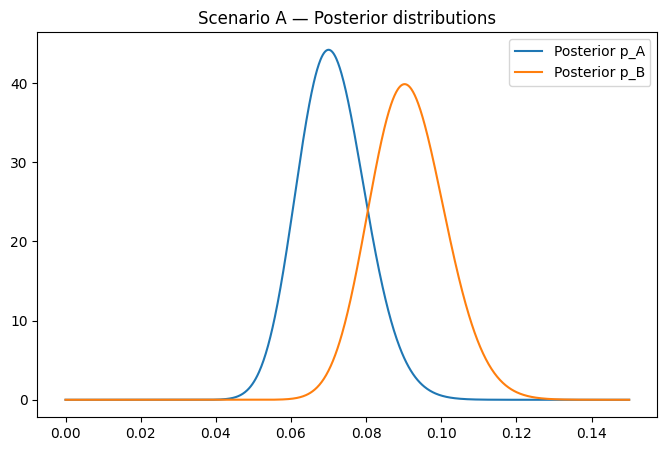

In [26]:
rowA = df_scenarios.iloc[0]
bayesA = bayesian_ab_summary(
    rowA["n_A"], rowA["x_A"], rowA["n_B"], rowA["x_B"],
    alpha_prior=1, beta_prior=1, n_samples=30_000
)

x_grid = np.linspace(0, 0.15, 1000)
pdf_A = beta.pdf(x_grid, bayesA.post_a_alpha, bayesA.post_a_beta)
pdf_B = beta.pdf(x_grid, bayesA.post_b_alpha, bayesA.post_b_beta)

plt.figure(figsize=(8, 5))
plt.plot(x_grid, pdf_A, label="Posterior p_A")
plt.plot(x_grid, pdf_B, label="Posterior p_B")
plt.title("Scenario A — Posterior distributions")
plt.legend()
plt.show()


# 21. Frequentist vs Bayesian — Which is better for product experimentation?

## If your goal is **decision-making**:
Bayesian is **almost always better**:
- Gives **P(B > A)** directly
- Handles low sample sizes gracefully
- Encourages rational decisions under uncertainty
- Produces interpretable lift distributions

## If your goal is **rigorous statistical control**:
Frequentist is better:
- Controls Type I error rates
- Required in regulatory/medical settings
- Interpretable for classical statisticians

## Most modern product experimentation platforms (e.g. Google, Airbnb, YouTube):
Use **Frequentist for reporting**,  
but **Bayesian for ranking, decision-making, and auto-rollouts**.

---


